In [ ]:
!pip install git+https://github.com/modestyachts/ImageNetV2_pytorch

  Cloning https://github.com/modestyachts/ImageNetV2_pytorch to /tmp/pip-req-build-aevdsd_1
  Running command git clone -q https://github.com/modestyachts/ImageNetV2_pytorch /tmp/pip-req-build-aevdsd_1
  Created wheel for imagenetv2-pytorch: filename=imagenetv2_pytorch-0.1-cp37-none-any.whl size=2666 sha256=b964f050b7074b3b7054774da6500bba08505fe5b7ffa12a074b2f8b7d026a66
  Stored in directory: /tmp/pip-ephem-wheel-cache-iipnov_x/wheels/f7/09/0d/03ded955ce95b04c9590b999ae9be076bb5d8f389650aa2147
Successfully built imagenetv2-pytorch


In [ ]:
!curl -O https://storage.googleapis.com/hml-public/other/dog.JPEG
!curl -O https://storage.googleapis.com/hml-public/other/imagenet1000_clsidx_to_labels.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87279  100 87279    0     0  1937k      0 --:--:-- --:--:-- --:--:-- 1937k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30564  100 30564    0     0   648k      0 --:--:-- --:--:-- --:--:--  648k


In [ ]:
from imagenetv2_pytorch import ImageNetV2Dataset
import torch
import torchvision
from torchvision import transforms
import PIL
import matplotlib.pyplot as plt
import numpy as np

Example Image

In [ ]:
img_path = './dog.JPEG'

img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299. / float(img.height))
new_h = 299 if wide else int(img.height * 299. / float(img.width))
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))

x = torch.from_numpy(np.array(img, dtype=float)) / 255.
x = x.unsqueeze(0).to('cuda', dtype=torch.float)
x = torch.transpose(x, 3,1)

inception = torchvision.models.inception_v3(pretrained=True)
inception.cuda()
inception.eval()

import ast
file = open("imagenet1000_clsidx_to_labels.txt", "r")
contents = file.read()
label_names = ast.literal_eval(contents)
file.close()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


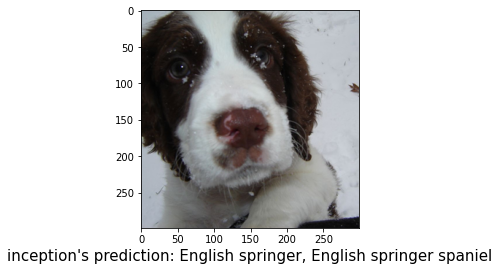

In [ ]:
def plot_prediction(inp):
  plt.imshow(torch.transpose(inp.cpu(), 1, 3).squeeze().numpy())
  with torch.no_grad():
    plt.xlabel(f"inception's prediction: {label_names[inception(inp).argmax().cpu().item()]}", fontsize=15)
plot_prediction(x)

In [ ]:
# Our target class will be a ping-pong ball:
target_label = 722
target_name = label_names[target_label]
target_y = torch.Tensor([target_label]).long()
print(target_name)

ping-pong ball


In [ ]:
import torch.nn as nn
def grad(model, inputs, y, dev='cuda', loss_func=nn.CrossEntropyLoss(reduction='sum')):
    y = y.to(dev)
    x = inputs.detach().to(dev).requires_grad_(True)

    model.to(dev)
    model.zero_grad()
    output = model(x)

    loss = loss_func(output, y)
    loss.backward()

    g = x.grad.detach()
    return g

def pgd_attack(targ_model, X, Y, grad_fn=grad, num_steps=10, eps=0.03):
    X = X.cuda()
    Y = Y.cuda()
    
    if eps == 0.:
        return X.detach()

    alpha = eps / np.sqrt(num_steps)

    def proj(z, maxnorm):
      return torch.clamp(z, -eps, eps)

    def normalize(z):
      return torch.sign(z)

    def nan_to_zero(z):
        return torch.where(torch.isnan(z), torch.zeros_like(z), z)  # nan --> 0

    delta = torch.zeros_like(X).cuda()

    for _ in range(num_steps):
        g = grad_fn(targ_model, X + delta, Y)
        g = nan_to_zero(g)

        with torch.no_grad():
            d_step = -alpha * normalize(g)
            delta = delta + d_step
            delta = proj(delta, maxnorm=eps)
            delta = delta.detach()

    x_adv = X + delta
    return x_adv.detach()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


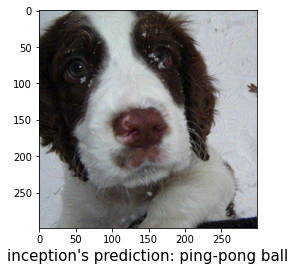

In [ ]:
x_adv = pgd_attack(inception, x, target_y)
plot_prediction(x_adv)

Load ImageNet V2

In [ ]:
batch_size = 5

# preprocess transform for ImageNet V2
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

images = ImageNetV2Dataset(transform=preprocess)
loader = torch.utils.data.DataLoader(images, batch_size=batch_size, num_workers=16)

Dataset matched-frequency not found on disk, downloading....


100%|██████████| 1.26G/1.26G [00:35<00:00, 35.7MiB/s]


Extracting....


In [ ]:
# Iterate over the images of ImageNet V2.
# Use only a small subsample because PGD to create adversarial examples is computationally expensive.

num_imgs = 0
for i, (xB, yB) in enumerate(loader):
    if num_imgs >= 200:
        break

    # .......
    num_imgs += len(xB)